# Wstęp

Będziemy trenować model generować obrazy nowego konceptu którego wcześniej nie znał

Czym jest koncept? Może to być np konkretna osoba, zwierze czy obiekt, możemy np. wytrenować model do generowania zdjęć naszego psa

Jak to zrobimy?
Nauczym model nowego słowa oznaczającego nasz koncept, jeśli np mamy psa możemy naczyć model co oznacz słowo `<PIMPEK>` i potem użyć go do wygenerowania nowych obrazów używając prompta np."Photo of `<PIMPEK>` in a bucket"

https://textual-inversion.github.io/
https://medium.com/@onkarmishra/how-textual-inversion-works-and-its-applications-5e3fda4aa0bc


# Weryfikacja czy używamy GPU

Zmień runtime na GPU

In [ ]:
#@markdown Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla T4, 15360 MiB, 15101 MiB


# Instalacja Bliblitek

In [ ]:
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py

In [ ]:
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py


In [ ]:
%pip install -qq git+https://github.com/ShivamShrirao/diffusers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
%pip install -q -U --pre triton


In [ ]:


%pip install -q accelerate transformers ftfy bitsandbytes==0.35.0 gradio natsort safetensors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.7

In [ ]:
%pip install -U xformers --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00


In [ ]:
%pip install xformers

# Wrzuć zdjęcia swojego konceptu

Prześlij pliki nowego konceptu którego chcesz nauczyć model (osoby, swojego zwierzaka itd.) na google colab używając wyboru plików po lewej, zapisz zdjęcia w osobnym katalogu

Min, 5 zjęć ale im więcej tym lepiej

#Stwórz słownik z listą konceptów których powinien nauczyć się model

Stwórz listę konceptów których powinien nauczyć się model
Każdy element listy powinien zawierać klucz i wartość:
* `instance_prompt` - prompt którym będziemy uczyć model nowego konceptu np. "photo of Pimpek dog" gdzie "Pimpek" to np. imie naszego psa którego generować ma nauczyć sie model. Nazwa ta powinna być unikalna i nie występować normlanie w słowniku, można stworzyć ją sztucznie np "<zwx>"
* `instance_prompt` - prompt którego użyje model do wygenerowania klasy naszego konceptu (np. jeśli chcemy nauczyć model generować zdjęcia naszego psa to instance prompt powinien brzmieć "photo of a dog")
* `instance_data_dir` - ścierzkę do katalogu gdzie wrzucimy nasze zdjęcia
* `instance_data_dir` - ścierzkę do katalogu gdzie model wygenruje ogólne przykłady danej klasy np. psa. Tam nie musimy nic wrzucać, model wygeneruje sam te zdjęcia



Zapisz plik jako `concepts_list.json`




przykład

In [ ]:
!cat concepts_list.json

[
    {
        "instance_prompt": "photo of Masyanya cat",
        "class_prompt": "photo of a cat",
        "instance_data_dir": "/content/Masyanya",
        "class_data_dir": "/content/cat"
    }
]

# Trening modelu

Możesz poekperymentować z innymi modelami ale domyślnie użyjemy stable-diffusion-v1-5

In [ ]:
MODEL_NAME = "runwayml/stable-diffusion-v1-5"

In [ ]:
#uzupełnij ścierzkę gdzie zapiszą się wagi modeli
OUTPUT_DIR = "/content/stable_diffusion_weights/Masyanya"

Uruchom trening

Możesz poeksperymentować z różnymi parametrami takimi jak `max_train_steps`

Trening powinien potrwać ok 10min przy 5 obrazach, jeśli mamy więcej obrazów może to zająć dłużej

In [ ]:
!python3 train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
  --output_dir=$OUTPUT_DIR \
  --revision="fp16" \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --seed=1337 \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=50 \
  --sample_batch_size=4 \
  --max_train_steps=800 \
  --save_interval=10000 \
  --save_sample_prompt="photo of Masyanya cat" \
  --concepts_list="/content/concepts_list.json"

2023-12-05 05:07:34.953392: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 05:07:34.953447: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 05:07:34.953488: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 05:07:36.614760: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
config.json: 100% 547/547 [00:00<00:00, 2.74MB/s]
diffusion_pytorch_model.safetensors: 100% 335M/335M [00:04<00:00, 72.0MB/s]
model_index.json: 100% 543/543 [00:00<00:00, 2.96MB/s]
safety_checker/model.safetensors not found
Fetching 15 fi

In [ ]:
#wybieramy ostatnie wagi
from natsort import natsorted
from glob import glob
import os
WEIGHTS_DIR = natsorted(glob(OUTPUT_DIR + os.sep + "*"))[-1]


# Predykcja

In [ ]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display

model_path = WEIGHTS_DIR

pipe = StableDiffusionPipeline.from_pretrained(model_path, safety_checker=None, torch_dtype=torch.float16).to("cuda")
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()
g_cuda = None

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/24 [00:00<?, ?it/s]

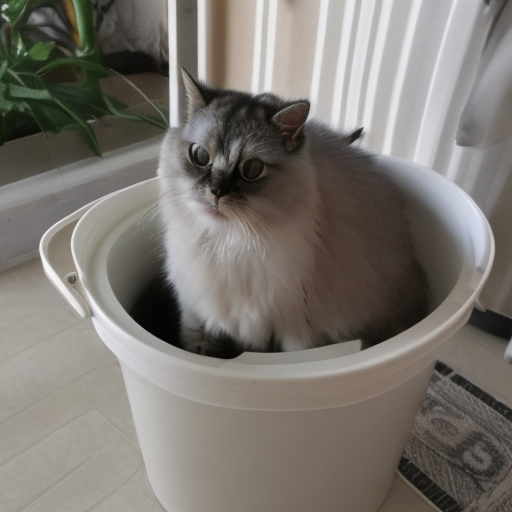

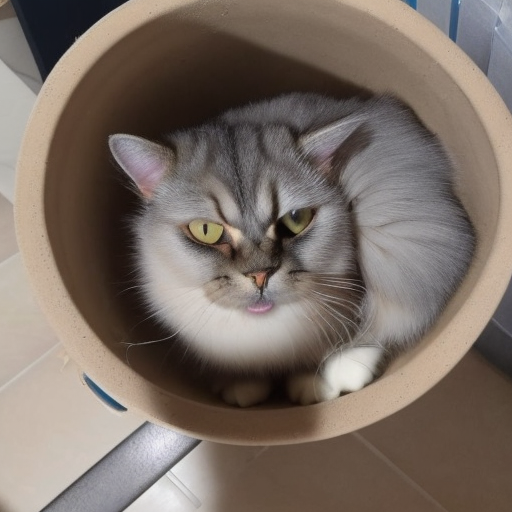

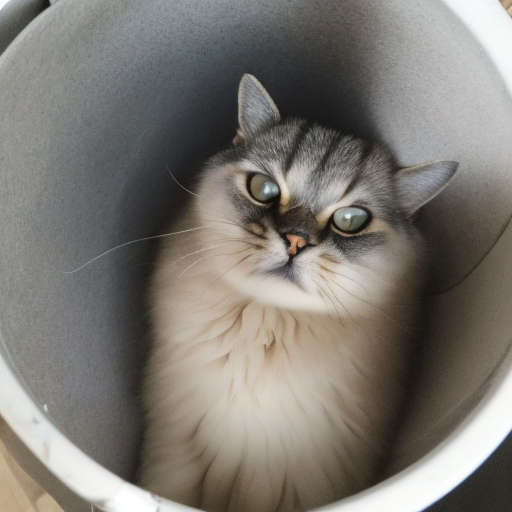

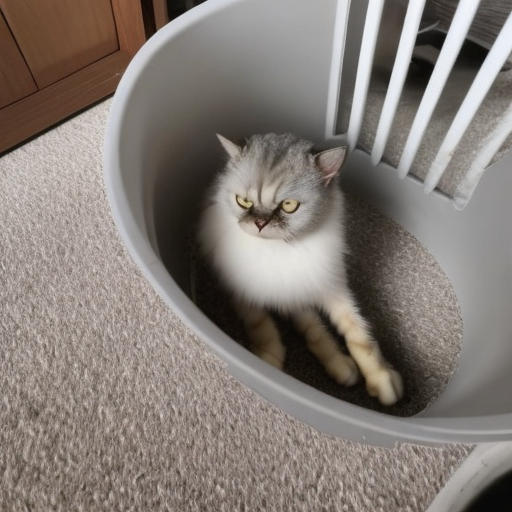

In [ ]:
prompt = "photo of Masyanya cat in a bucket" # uzupełnij prompt - co mam wygenerować model użwając nowego koncpetu
negative_prompt = ""
num_samples = 4
guidance_scale = 7.5
num_inference_steps = 24
height = 512
width = 512

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for img in images:
    display(img)

## (Opcjonalne) konwersja wag żeby użyć ich w systemie AUTOMATIC1111.


Jeśli chcesz skorzystać z wytrenowanego przez siebie modelu później w aplikacji graficznej https://github.com/AUTOMATIC1111/stable-diffusion-webui musisz skonwertować wagi i je pobrać

In [ ]:
#@markdown Run conversion.
ckpt_path = WEIGHTS_DIR + "/model.ckpt"

half_arg = ""
#@markdown  Whether to convert to fp16, takes half the space (2GB).
fp16 = True #@param {type: "boolean"}
if fp16:
    half_arg = "--half"
!python convert_diffusers_to_original_stable_diffusion.py --model_path $WEIGHTS_DIR  --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")